In [ ]:
!pip install tensorflow
!pip install keras

# Importing necessary libraries and modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the dataset and labels.

In [4]:
def load_dataset_and_labels(dataset_dir):
  dataset = []
  labels = []

  for disease_type in os.listdir(dataset_dir):
    disease_type_dir = os.path.join(dataset_dir, disease_type)
    print(disease_type_dir)

    if os.path.isdir(disease_type_dir):
      for image_file in os.listdir(disease_type_dir):
        image_path = os.path.join(disease_type_dir, image_file)
        image = load_and_preprocess_image(image_path)
        dataset.append(image)
        labels.append(disease_type)

  dataset =  np.array(dataset)
  labels = np.array(labels)

  return dataset, labels

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, (224, 224))
  img = img / 255.0

  return img

  # Path to the dataset directory in your Google Drive
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Medical-imaging-dataset'

# Load dataset and labels
data, labels = load_dataset_and_labels(dataset_dir)

/content/drive/MyDrive/Colab Notebooks/Medical-imaging-dataset/Peritonitis
/content/drive/MyDrive/Colab Notebooks/Medical-imaging-dataset/Diverticulosis
/content/drive/MyDrive/Colab Notebooks/Medical-imaging-dataset/Neoplasm
/content/drive/MyDrive/Colab Notebooks/Medical-imaging-dataset/Ureters


# Visualize images.

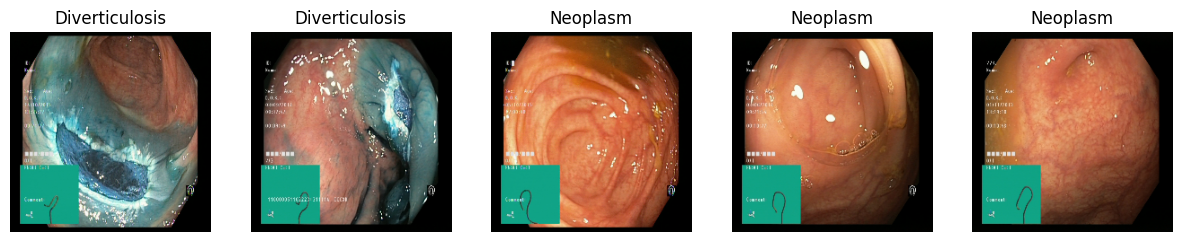

In [5]:
def visualize_images(dataset, labels, num_images):

  fig, axes = plt.subplots(1, num_images, figsize=(15,3))

  for i in range(num_images):
    # Generate a random integer between a range (exclusive)
    random_number_np = np.random.randint(0, 4001)

    axes[i].imshow(dataset[random_number_np])
    axes[i].set_title(labels[random_number_np])
    axes[i].axis('off')

  plt.show()

# Visualize 5 random images
visualize_images(data, labels, num_images=5)

# Split dataset into training, validation and test sets.

In [6]:
# Split dataset into training and temporary set (80% training, 20% temp)
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (50% temp, 50% validation)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

In [7]:
# Calculate the count of each disease label
train_label_counts = {label: np.sum(train_labels == label) for label in np.unique(train_labels)}
val_label_counts = {label: np.sum(val_labels == label) for label in np.unique(val_labels)}
test_label_counts = {label: np.sum(test_labels == label) for label in np.unique(test_labels)}

# Calculate the total number of samples
total_train_samples = len(train_labels)
total_val_samples = len(val_labels)
total_test_samples = len(test_labels)

# Calculate the percentage of each disease label
train_percentages = {label: (count / total_train_samples) * 100 for label, count in train_label_counts.items()}
val_percentages = {label: (count / total_val_samples) * 100 for label, count in val_label_counts.items()}
test_percentages = {label: (count / total_test_samples) * 100 for label, count in test_label_counts.items()}

# Print the percentages
print("Percentage of each disease in train_labels:")
for label, percentage in train_percentages.items():
    print(f"{label}: {percentage:.2f}%")

print("\nPercentage of each disease in val_labels:")
for label, percentage in val_percentages.items():
    print(f"{label}: {percentage:.2f}%")

print("\nPercentage of each disease in test_labels:")
for label, percentage in test_percentages.items():
    print(f"{label}: {percentage:.2f}%")

Percentage of each disease in train_labels:
Diverticulosis: 24.59%
Neoplasm: 25.19%
Peritonitis: 24.72%
Ureters: 25.50%

Percentage of each disease in val_labels:
Diverticulosis: 28.00%
Neoplasm: 26.00%
Peritonitis: 24.25%
Ureters: 21.75%

Percentage of each disease in test_labels:
Diverticulosis: 25.25%
Neoplasm: 22.50%
Peritonitis: 28.00%
Ureters: 24.25%


In [39]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit laber encoder and transform labels to numerical values
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert numerical labels to one-hot encoded vectors
train_labels_categorical = to_categorical(train_labels_encoded, 4)
val_labels_categorical = to_categorical(val_labels_encoded, 4)
test_labels_categorical = to_categorical(test_labels_encoded, 4)

# Encoded label classes
print(f"Encoded label classes:, {label_encoder.classes_}\n")
print(f"Maximum pixel value after normalization: {np.max(train_data)}\n")
print(f"Shape of training set: {train_data.shape}\n")

Encoded label classes:, ['Diverticulosis' 'Neoplasm' 'Peritonitis' 'Ureters']

Maximum pixel value after normalization: 1.0

Shape of training set: (3200, 224, 224, 3)



# Model Architecture.

In [9]:
# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add a classification head
x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # num_classes is the number of classes in your dataset

# Create the VGG16 model with the new classification head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.93:
                print("\nReached 93% accuracy so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

# Train the model.

In [11]:
# Compile de model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

# Train the model
history = model.fit(train_data, train_labels_categorical,
                    validation_data=(val_data, val_labels_categorical),
                    epochs=15, batch_size=32, callbacks=myCallback())


Epoch 1/15
  6/100 [>.............................] - ETA: 16s - loss: 28.1880 - accuracy: 0.2917

100/100 [==============================] - 34s 225ms/step - loss: 2.3676 - accuracy: 0.7294 - val_loss: 0.2210 - val_accuracy: 0.9225
Epoch 2/15
100/100 [==============================] - 19s 192ms/step - loss: 0.2303 - accuracy: 0.9147 - val_loss: 0.2300 - val_accuracy: 0.9200
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9375
Reached 93% accuracy so cancelling training!
100/100 [==============================] - 19s 189ms/step - loss: 0.1576 - accuracy: 0.9375 - val_loss: 0.2325 - val_accuracy: 0.9175


# Display loss curves.

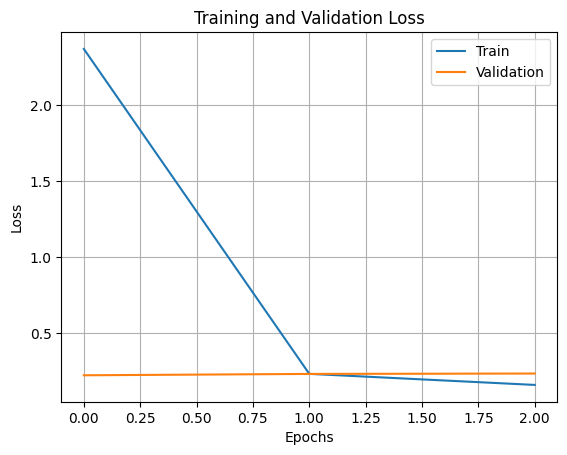

In [12]:
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

# Plot loss curves
plt.plot(loss_train, label='Train')
plt.plot(loss_val, label='Validation')

# Highlight minimun validation loss
min_val_loss = min(loss_val)

# Label axis and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

# Add grid lines
plt.grid(True)

# Show plot
plt.show()

# Display accuracy curves.

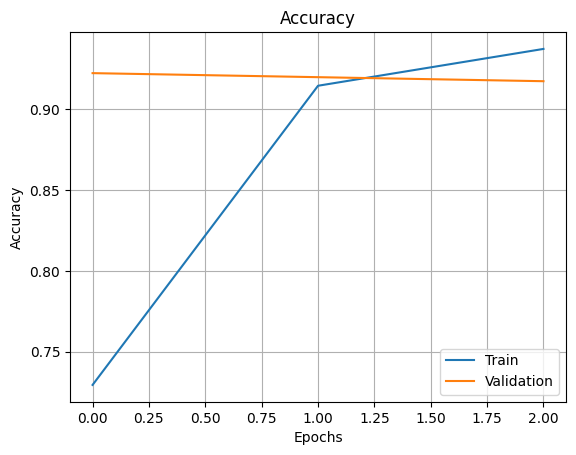

In [13]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

# Plot accuracy curves
plt.plot(accuracy_train, label='Train')
plt.plot(accuracy_val, label='Validation')

# Highlight minimun validation loss
min_val_loss = min(loss_val)

# Label axis and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

# Add grid lines
plt.grid(True)

# Show plot
plt.show()

# Evaluate the trained model.




In [14]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data, test_labels_categorical)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 2s 130ms/step - loss: 0.2549 - accuracy: 0.9325
Test Loss: 0.25494635105133057
Test Accuracy: 0.9325000047683716


In [28]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
# Use the trained model to make predictions on the validation test
y_pred = model.predict(val_data)

# Convert back to class labels
y_true = np.argmax(val_labels_categorical, axis=1)

# Additional evaluation metrics
accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
recall = recall_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
roc_auc = roc_auc_score(val_labels_categorical, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)

13/13 [==============================] - 2s 148ms/step
Accuracy: 0.9175
Recall: 0.9175
ROC AUC Score: 0.9889014154015461


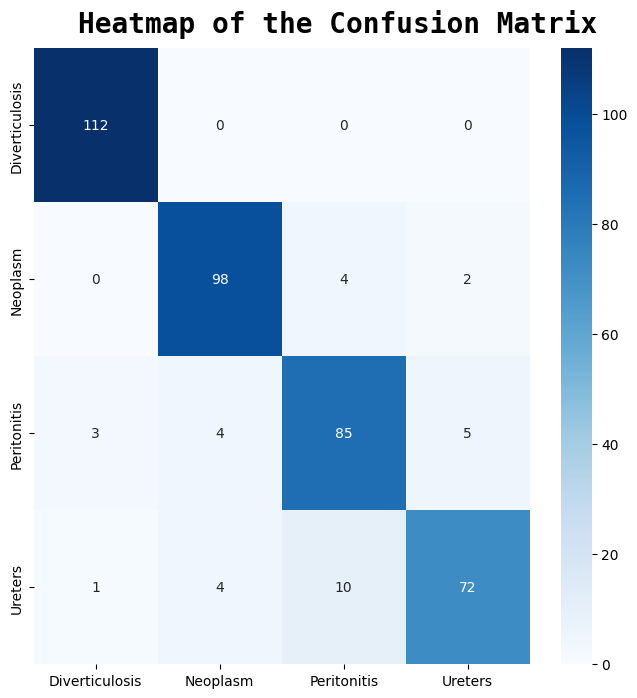

In [82]:
# Assuming y_true contains the true labels and y_pred contains the predicted labels
# Replace y_true and y_pred with your actual true and predicted labels
# Make sure they are in the same format (e.g., one-hot encoded or integer labels)
# Here, I assume they are integer labels
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.heatmap(conf_matrix, ax=ax, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot=True, fmt='d', cmap='Blues')

fig.text(s='Heatmap of the Confusion Matrix', size=20, fontweight='bold', fontname='monospace', y=0.9, x=0.18, alpha=1)

plt.show()